In [2]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

In [2]:
from collections import Counter
import requests

with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [4]:
df_features = pd.read_csv("features.csv")

df_target = pd.read_csv("target.csv")

/home/facundo/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
df = df_features.merge(df_target, left_on='id', right_on='id')

In [22]:
df.head()

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no


In [23]:
df.isnull()


,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116364,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116365,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
116366,False,False,False,True,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [24]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                   object
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

In [25]:
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')

In [26]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                  float64
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

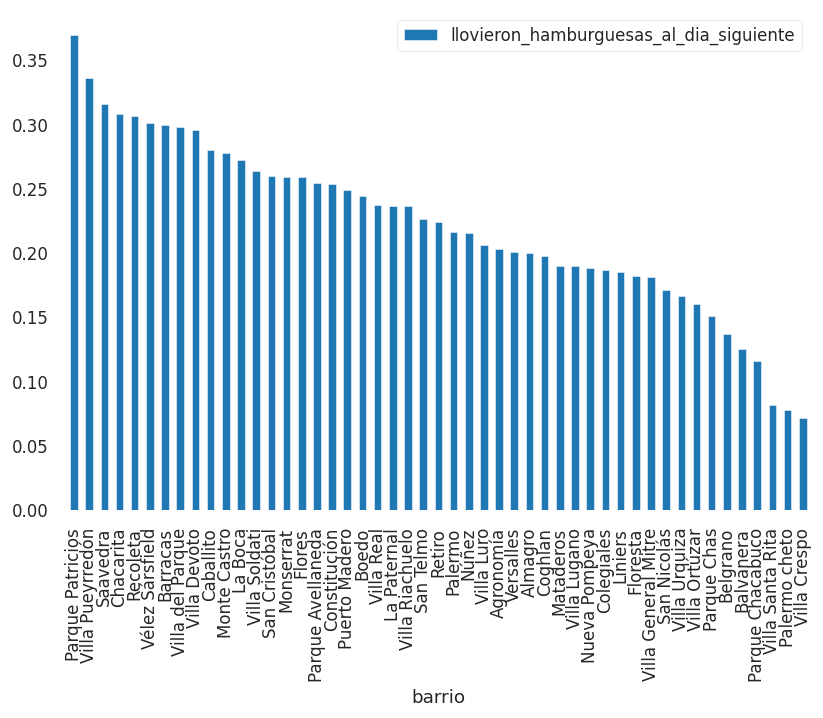

In [62]:
plt.rcParams["figure.dpi"] = 120
lluvia_por_barrios = df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']][df['llovieron_hamburguesas_al_dia_siguiente']=='si'].groupby('barrio').count()

lluvia_por_barrios /=  df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('barrio').count()

lluvia_por_barrios.sort_values(by = 'llovieron_hamburguesas_al_dia_siguiente', ascending=False).plot(kind = 'bar')

plt.show()

In [28]:
df['llovieron_hamburguesas_al_dia_siguiente'].value_counts()


no    88282
si    25447
Name: llovieron_hamburguesas_al_dia_siguiente, dtype: int64

In [77]:
barrios_si = df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']][df['llovieron_hamburguesas_al_dia_siguiente'].isnull()].groupby('barrio').count()
barrios_si.sort_values(by = 'llovieron_hamburguesas_al_dia_siguiente', ascending=False)



,llovieron_hamburguesas_al_dia_siguiente
barrio,
Agronomía,0
Villa Crespo,0
Parque Patricios,0
Puerto Madero,0
Recoleta,0
Retiro,0
Saavedra,0
San Cristóbal,0
San Nicolás,0
